In [3]:

from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import pickle
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from preprocessor import *



In [4]:
links = ['https://h1bdata.info/index.php?em=&job=Data+Scientist&city=SAN+JOSE&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=SANTA+CLARA&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=SUNNYVALE&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=MOUNTAIN+VIEW&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=CUPERTINO&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=MENLO+PARK&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=PALO+ALTO&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=REDWOOD+CITY&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=SAN+MATEO&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=SAN+FRANCISCO&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=SEATTLE&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=REDMOND&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=SANTA+MONICA&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=LOS+ANGELES&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=AUSTIN&year=All+Years',
         'https://h1bdata.info/index.php?em=amazon&job=Data+Scientist+I&city=&year=All+Years'
        ]

# Scrape table data from each of the above links and store in a list
jobs_list = []
for link in links:
    page_link = link
    page_response = requests.get(page_link, timeout=1000)
    page_content = BeautifulSoup(page_response.content, 'lxml')

    for row in page_content.find_all('tr')[1:]:
        row_data = []
        for i in row:
            row_data.append(i.text)
        jobs_list.append(row_data)

In [4]:
# Put everything into dataframes for easier processing
ds_jobs_df = pd.DataFrame()
ds_jobs_df['company'] = [i[0] for i in jobs_list]
ds_jobs_df['title'] = [i[1] for i in jobs_list]

ds_jobs_df['salary'] = [i[2].replace(',','') for i in jobs_list]
ds_jobs_df['salary'] = ds_jobs_df['salary'].astype(float)

ds_jobs_df['location'] = [i[3] for i in jobs_list]

ds_jobs_df['date'] = [i[4] for i in jobs_list]
ds_jobs_df['date'] = pd.to_datetime(ds_jobs_df['date'])
ds_jobs_df['year'] = [i.year for i in ds_jobs_df['date']]

# Drop pre 2014 data (very few observations pre 2014)
ds_jobs_df.drop(ds_jobs_df[ds_jobs_df['year']<2014].index, axis=0, inplace=True)

# Drop salaries over $1,000,000
ds_jobs_df.drop(ds_jobs_df[ds_jobs_df['salary']>1000000].index, axis=0, inplace=True)

# Sort by company and year
ds_jobs_df.sort_values(by=['year','company'], inplace=True, ascending=True)

In [22]:
#ds_jobs_df.to_csv('jobs.csv')
prep.overview(ds_jobs_df)


Dataset contains 3040 rows and 6 columns

Data types of the raw (uncleaned) data:
company             object
title               object
salary             float64
location            object
date        datetime64[ns]
year                 int64
dtype: object

Categorical features of the dataset: ['company', 'title', 'location']

Numeric features of the dataset: ['salary', 'date', 'year']

Checking for features with null values...

year        0
date        0
location    0
salary      0
title       0
company     0
dtype: int64


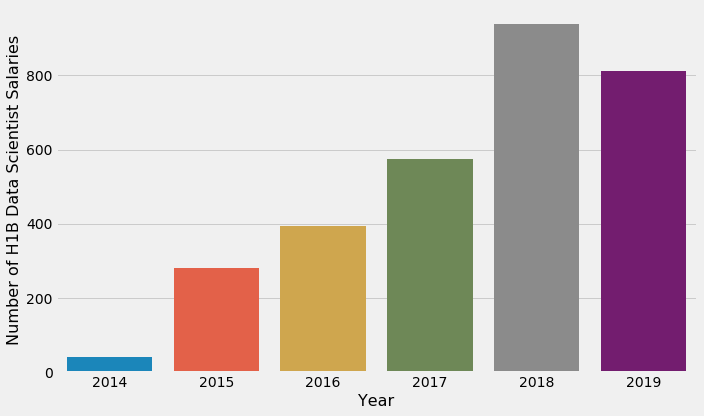

In [6]:
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x=ds_jobs_df['year'].value_counts().sort_index().index, 
                 y=ds_jobs_df['year'].value_counts().sort_index().values)
ax.set_xlabel("Year",fontsize=16)
ax.set_ylabel("Number of H1B Data Scientist Salaries",fontsize=16)
plt.tight_layout()
plt.savefig(fname='num_jobs', dpi=150)

In [7]:
ds_jobs_df['salary'].median()

120000.0

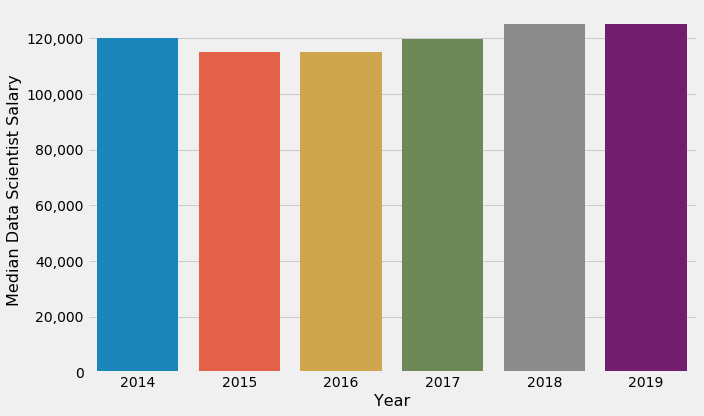

In [10]:
median_salary = ds_jobs_df.groupby(by=['year']).median().reset_index()

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x=median_salary['year'], 
                 y=median_salary['salary'])
ax.set_xlabel("Year",fontsize=16)
ax.set_ylabel("Median Data Scientist Salary",fontsize=16)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tight_layout()
plt.savefig(fname='median_salary', dpi=150)

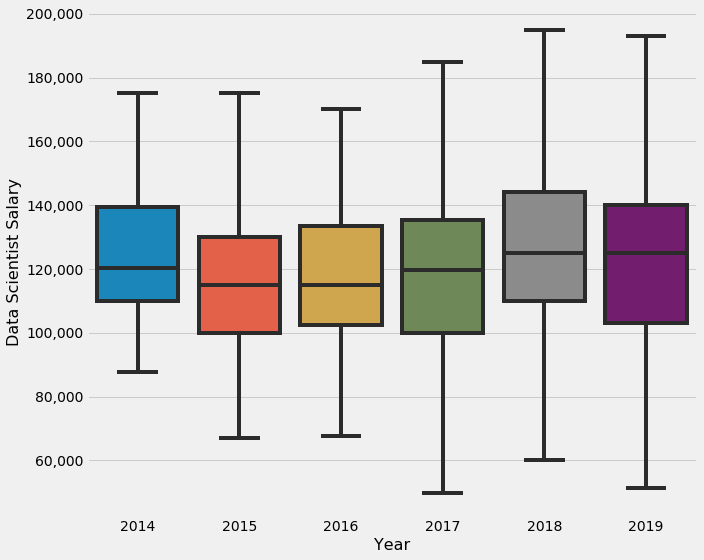

In [11]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(x='year', y='salary', data=ds_jobs_df, showfliers=False);
ax.set_xlabel("Year",fontsize=16)
ax.set_ylabel("Data Scientist Salary",fontsize=16)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tight_layout()
plt.savefig(fname='salary_box', dpi=150)

In [12]:
print('All 25th perctile: ' + str(ds_jobs_df['salary'].quantile(0.25)))
print('All 50th perctile: ' + str(ds_jobs_df['salary'].quantile(0.50)))
print('All 75th perctile: ' + str(ds_jobs_df['salary'].quantile(0.75)))

All 25th perctile: 105000.0
All 50th perctile: 120000.0
All 75th perctile: 140000.0


In [13]:
print('2015 25th perctile: ' + str(ds_jobs_df[ds_jobs_df['year']==2015]['salary'].quantile(0.25)))
print('2015 50th perctile: ' + str(ds_jobs_df[ds_jobs_df['year']==2015]['salary'].quantile(0.50)))
print('2015 75th perctile: ' + str(ds_jobs_df[ds_jobs_df['year']==2015]['salary'].quantile(0.75)))

2015 25th perctile: 100000.0
2015 50th perctile: 115000.0
2015 75th perctile: 130000.0


In [14]:
print('2019 25th perctile: ' + str(ds_jobs_df[ds_jobs_df['year']>=2019]['salary'].quantile(0.25)))
print('2019 50th perctile: ' + str(ds_jobs_df[ds_jobs_df['year']>=2019]['salary'].quantile(0.50)))
print('2019 75th perctile: ' + str(ds_jobs_df[ds_jobs_df['year']>=2019]['salary'].quantile(0.75)))

2019 25th perctile: 103000.0
2019 50th perctile: 125000.0
2019 75th perctile: 140000.0


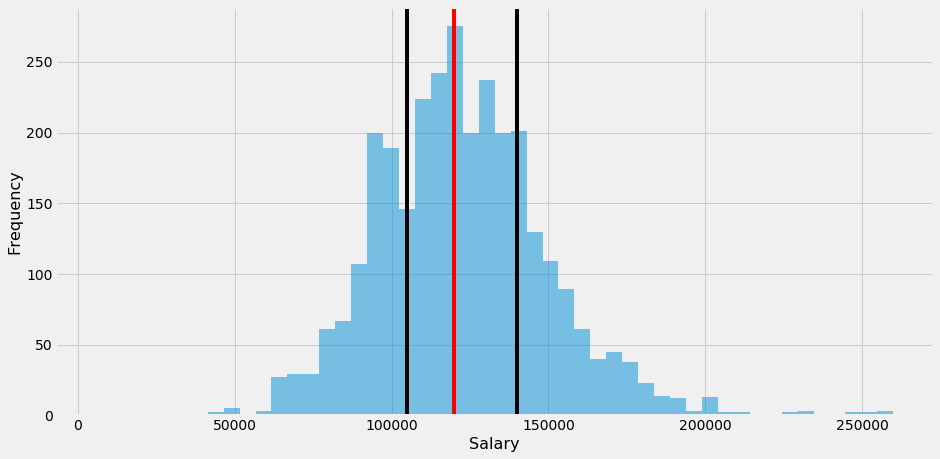

In [15]:
# Histogram of salaries
fig, ax = plt.subplots(figsize=(14,7))
ax = plt.hist(ds_jobs_df['salary'], bins=50, alpha=0.5)
plt.axvline(ds_jobs_df['salary'].quantile(0.25), c='black')
plt.axvline(ds_jobs_df['salary'].quantile(0.50), c='red')
plt.axvline(ds_jobs_df['salary'].quantile(0.75), c='black')

plt.xlabel('Salary',fontsize=16)
plt.ylabel('Frequency',fontsize=16)

plt.savefig(fname='salary_hist', dpi=150)
plt.show()

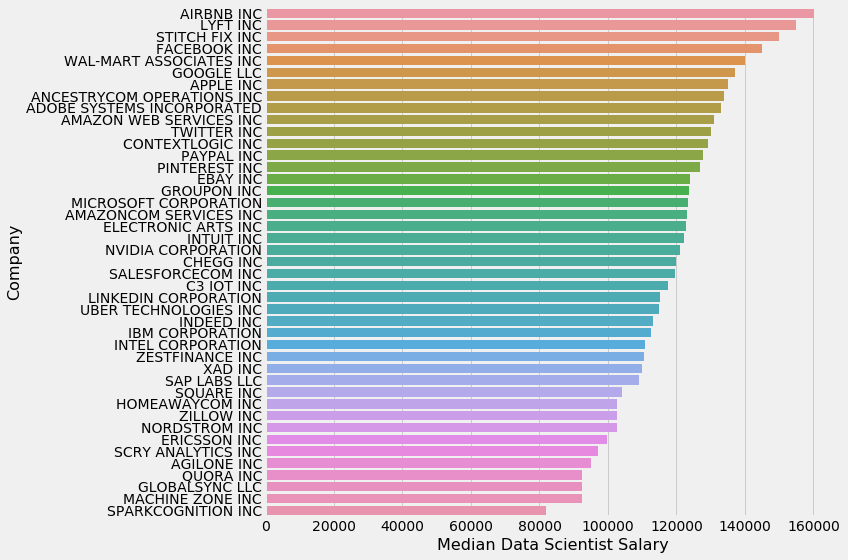

In [16]:
company_df = pd.DataFrame()
company_df['company'] = ds_jobs_df[['company','salary']].groupby(by=['company']).count().reset_index()['company']
company_df['count'] = ds_jobs_df[['company','salary']].groupby(by=['company']).count().reset_index()['salary']
company_df['salary'] = ds_jobs_df[['company','salary']].groupby(by=['company']).median().reset_index()['salary']
sorted_df = company_df.sort_values(by='salary', ascending=False)
sorted_df= sorted_df[sorted_df['count']>=10]

fig, ax = plt.subplots(figsize=(12,8))
ax = sns.barplot(x=sorted_df['salary'], 
                 y=sorted_df['company'])
ax.set_xlabel("Median Data Scientist Salary",fontsize=16)
ax.set_ylabel("Company",fontsize=16)
plt.tight_layout()
plt.savefig(fname='company_median_salary', dpi=150)

In [18]:
#company_df.to_csv('companies.csv')

In [19]:
sorted_df.iloc[0:10]

,company,count,salary
25,AIRBNB INC,106,160029.0
355,LYFT INC,47,155000.0
548,STITCH FIX INC,31,150000.0
226,FACEBOOK INC,317,145000.0
646,WAL-MART ASSOCIATES INC,64,140000.0
268,GOOGLE LLC,60,137000.0
59,APPLE INC,38,135193.5
52,ANCESTRYCOM OPERATIONS INC,10,134000.0
16,ADOBE SYSTEMS INCORPORATED,15,133099.0
46,AMAZON WEB SERVICES INC,11,131000.0


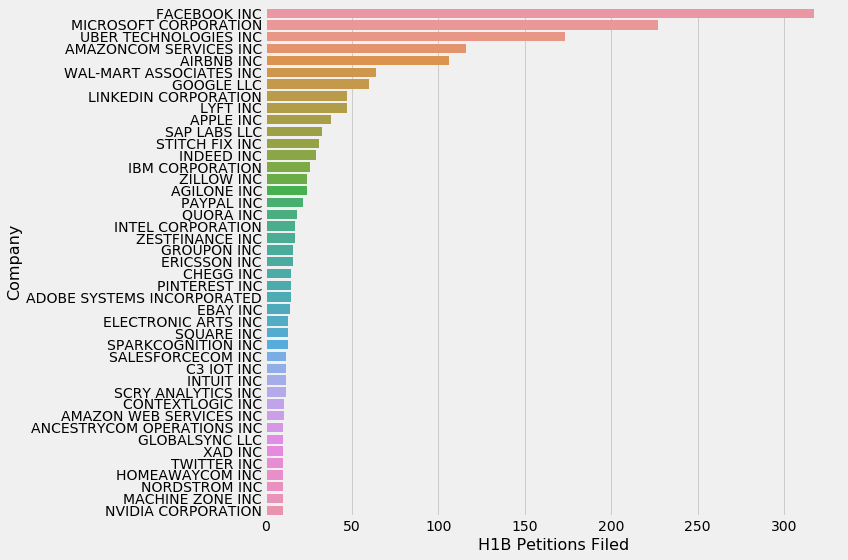

In [20]:
sorted_df = company_df.sort_values(by='count', ascending=False)
sorted_df= sorted_df[sorted_df['count']>=10]

fig, ax = plt.subplots(figsize=(12,8))
ax = sns.barplot(x=sorted_df['count'], 
                 y=sorted_df['company'])
ax.set_xlabel("H1B Petitions Filed",fontsize=16)
ax.set_ylabel("Company",fontsize=16)
plt.tight_layout()
plt.savefig(fname='company_hired', dpi=150)

In [32]:
# Compare Big Tech to Everyone Else

In [34]:
# Compare Bay Area to Everyone Else both in numbers of jobs and salaries (signs of outsourcing to other states?)